### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5891c000 @  0x7f3a345932a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 19.7MB/s 
    100% |████████████████████████████████| 2.0MB 5.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})
plt.rcParams["axes.grid"] = False

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


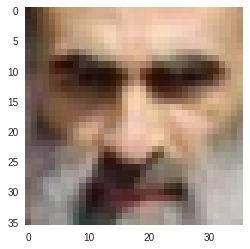

In [0]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 0.5.0a0+a24163a
Using GPU


In [3]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [4]:
CODE_SIZE = 256

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 10*8*8),
    nn.ELU(),
    Reshape([-1, 10, 8, 8]),
    nn.ConvTranspose2d(10, 64, kernel_size=(5,5)),
    nn.ELU(),
    nn.ConvTranspose2d(64, 64, kernel_size=(5,5)),
    nn.ELU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(64, 32, kernel_size=(5,5)),
    nn.ELU(),
    nn.ConvTranspose2d(32, 32, kernel_size=(5,5)),
    nn.Conv2d(32, 3, kernel_size=(5,5))
)

if use_cuda: generator.cuda()

In [5]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generated_data.shape)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [5]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
print(IMG_SHAPE)

(3, 36, 36)


In [7]:
discriminator = nn.Sequential(nn.Conv2d(3,16,3),
                              nn.ELU(),
                              nn.MaxPool2d(2),
                              nn.Conv2d(16,64,3,2),
                              nn.ELU(),
                              nn.Conv2d(64,128,3,2),
                              nn.ELU(),
                              Flatten())
                              
                                                

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# and a final layer...
discriminator.add_module("disc_logit", nn.Linear(1152, 1))

if use_cuda: discriminator.cuda()

In [9]:
discriminator(sample_data_batch(5))

tensor([[ 0.0039],
        [ 0.0192],
        [-0.0051],
        [ 0.0093],
        [ 0.0021]], device='cuda:0', grad_fn=<ThAddmmBackward>)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [10]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = - torch.mean(logp_gen_is_real)
    
    return loss

In [11]:
loss = generator_loss(sample_noise_batch(32))

print(loss)


tensor(0.6910, device='cuda:0', grad_fn=<NegBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [9]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid( -disc_on_fake_data)
    
    loss = -torch.mean(logp_real_is_real+logp_gen_is_fake)
    return loss

In [13]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)


tensor(1.3801, device='cuda:0', grad_fn=<NegBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [8]:
def sample_images(nrow,ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0,2,3,1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i],cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i],cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [0]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

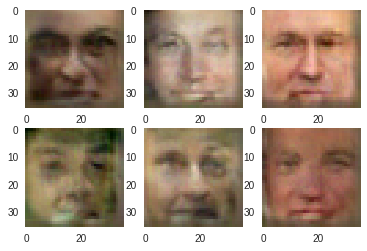

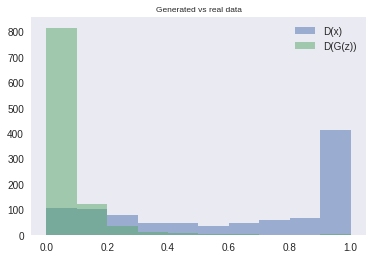

 28%|██▊       | 14249/50000 [6:06:38<15:20:16,  1.54s/it]

KeyboardInterrupt: ignored

In [16]:
from IPython import display
from tqdm import trange
batch_size = 400

for epoch in trange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

In [0]:
torch.save(discriminator.state_dict(), "disc.state")
torch.save(generator.state_dict(), "gen.state")

In [11]:
discriminator.load_state_dict(torch.load("disc.state"))
generator.load_state_dict(torch.load("gen.state"))

In [ ]:
from IPython import display
from tqdm import trange
batch_size = 200

for epoch in trange(5000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

/usr/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


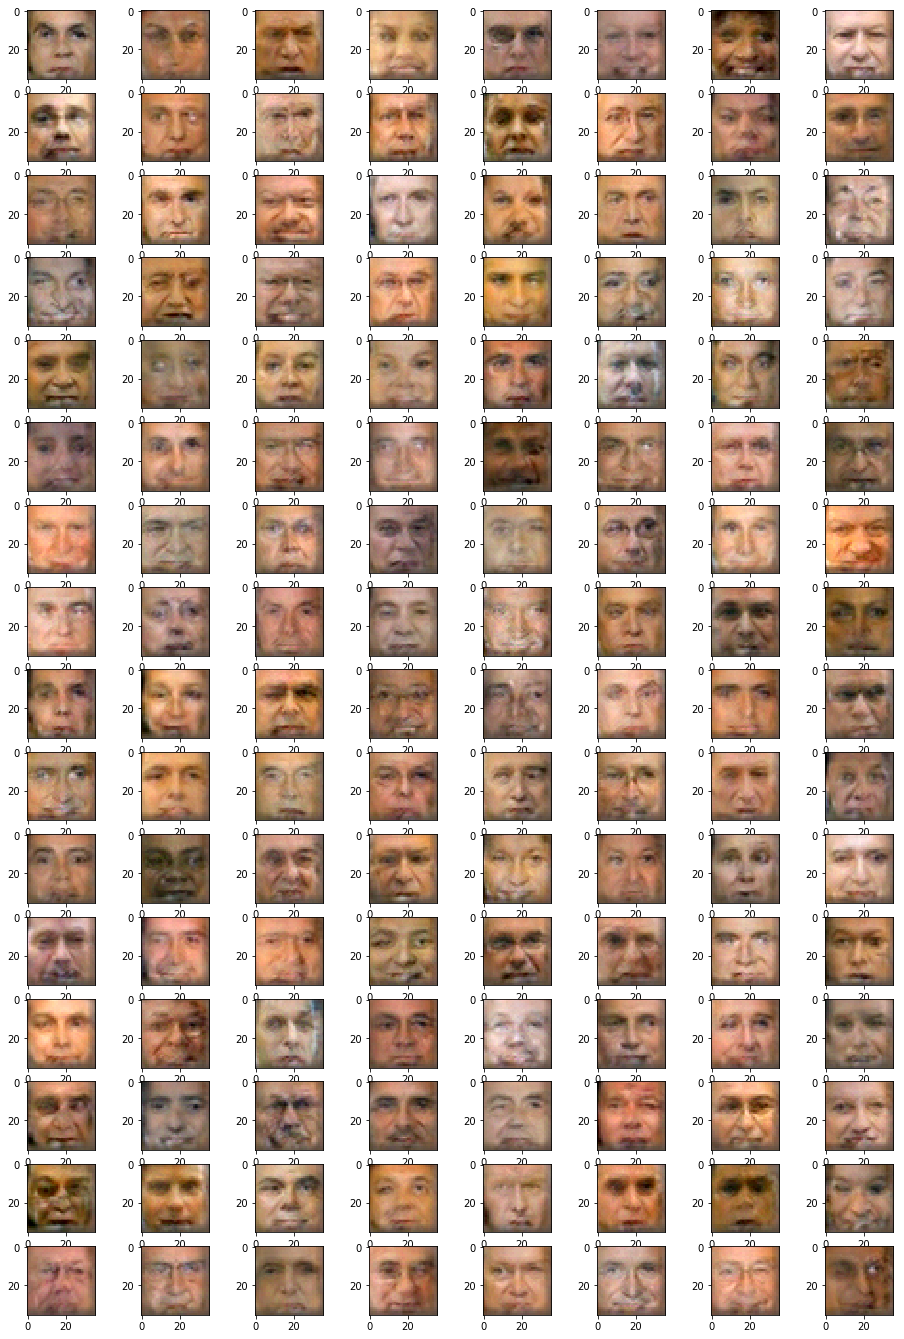

In [12]:
plt.figure(figsize=[16,24])
sample_images(16,8)